In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import joblib

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("all_houses_data.csv")

print("Dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics for key numerical features:")
print(df.describe().T)

# 3. Enhanced Preprocessing Functions
def analyze_skewness(df, numeric_cols):
    """Analyze skewness of numeric features to identify transformation needs"""
    skewness = {}
    for col in numeric_cols:
        if col in df.columns:
            skew_value = stats.skew(df[col].dropna())
            skewness[col] = skew_value
            print(f"{col}: Skewness = {skew_value:.4f}")
    
    return skewness

Dataset shape: (10171, 9)

Missing values:
house_id           0
sq_meters          0
price              0
geography          0
floorNumber        0
rooms              0
no_of_bathrooms    0
kitchens           0
livingRooms        0
dtype: int64

Basic statistics for key numerical features:
                   count          mean           std        min         25%  \
house_id         10171.0  1.604594e+07  1.473621e+06  1305675.0  15628300.5   
sq_meters        10171.0  1.120994e+02  1.253652e+02       10.0        64.0   
price            10171.0  3.298224e+05  4.213648e+05    20000.0    144000.0   
floorNumber      10171.0  7.007276e+00  2.658680e+00        0.0         6.0   
rooms            10171.0  2.261626e+00  2.146659e+00        0.0         1.0   
no_of_bathrooms  10171.0  1.350703e+00  1.317235e+00        0.0         1.0   
kitchens         10171.0  1.125946e+00  9.959069e+00        0.0         1.0   
livingRooms      10171.0  8.961754e-01  1.020265e+00        0.0         1.0  

In [3]:
def handle_missing_values(df, numeric_strategy='median', categorical_strategy='most_frequent', knn_cols=None):
    """Impute missing values in the dataframe with more sophisticated options"""
    df_clean = df.copy()
    
    # For numerical columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    if knn_cols is not None:
        # Use KNN imputation for specified columns
        knn_imputer = KNNImputer(n_neighbors=5)
        for col in knn_cols:
            if col in num_cols and df[col].isnull().sum() > 0:
                df_clean[col] = knn_imputer.fit_transform(df[[col]])
                
        # Remove KNN columns from standard imputation
        num_cols = [col for col in num_cols if col not in knn_cols]
    
    # Standard imputation for remaining numeric columns
    for col in num_cols:
        if df[col].isnull().sum() > 0:
            if numeric_strategy == 'median':
                val = df[col].median()
            elif numeric_strategy == 'mean':
                val = df[col].mean()
            df_clean[col] = df_clean[col].fillna(val)
    
    # For categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df[col].isnull().sum() > 0:
            if categorical_strategy == 'most_frequent':
                val = df[col].mode()[0]
            elif categorical_strategy == 'missing':
                val = 'missing'
            df_clean[col] = df_clean[col].fillna(val)
    
    return df_clean

In [4]:
def detect_and_handle_outliers(df, columns, method='iqr', threshold=1.5, max_iter=1):
    """Detect and handle outliers with option for iterative treatment"""
    df_clean = df.copy()
    
    for _ in range(max_iter):
        for col in columns:
            if method == 'iqr':
                Q1 = df_clean[col].quantile(0.25)
                Q3 = df_clean[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                
                # Calculate percentage of outliers
                outliers_pct = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).mean() * 100
                print(f"Column {col}: {outliers_pct:.2f}% outliers detected")
                
                # Winsorizing (capping) the outliers
                df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
            
            elif method == 'zscore':
                z_scores = stats.zscore(df_clean[col])
                abs_z_scores = np.abs(z_scores)
                filtered_entries = (abs_z_scores < threshold)
                
                # Calculate percentage of outliers
                outliers_pct = (~filtered_entries).mean() * 100
                print(f"Column {col}: {outliers_pct:.2f}% outliers detected")
                
                # Cap based on z-score
                mean = df_clean[col].mean()
                std = df_clean[col].std()
                df_clean[col] = df_clean[col].clip(lower=mean-threshold*std, upper=mean+threshold*std)
    
    return df_clean

In [5]:
def engineer_features(df):
    """Create new features with sophisticated domain-specific logic"""
    df_new = df.copy()
    
    # Basic features (from original code)
    if 'price' in df.columns and 'sq_meters' in df.columns:
        df_new['price_per_sqm'] = df['price'] / df['sq_meters']
    
    if 'rooms' in df.columns and 'sq_meters' in df.columns:
        df_new['rooms_x_sqm'] = df['rooms'] * df['sq_meters']
        df_new['sqm_per_room'] = df['sq_meters'] / (df['rooms'] + 0.1)  # Avoid division by zero
    
    if 'no_of_bathrooms' in df.columns and 'sq_meters' in df.columns:
        df_new['bathrooms_x_sqm'] = df['no_of_bathrooms'] * df['sq_meters']
        df_new['sqm_per_bathroom'] = df['sq_meters'] / (df['no_of_bathrooms'] + 0.1)
    
    if 'kitchens' in df.columns and 'livingRooms' in df.columns:
        df_new['kitchen_living_ratio'] = df['kitchens'] / (df['livingRooms'] + 0.1)
    
    # Advanced features
    if all(col in df.columns for col in ['rooms', 'no_of_bathrooms', 'kitchens', 'livingRooms']):
        df_new['total_rooms'] = df['rooms'] + df['no_of_bathrooms'] + df['kitchens'] + df['livingRooms']
        df_new['living_to_total_ratio'] = df['livingRooms'] / (df_new['total_rooms'] + 0.1)
        df_new['bathroom_to_room_ratio'] = df['no_of_bathrooms'] / (df['rooms'] + 0.1)
    
    # Polynomial features for key metrics
    if 'sq_meters' in df.columns:
        df_new['sq_meters_squared'] = df['sq_meters'] ** 2
    
    if 'rooms' in df.columns:
        df_new['rooms_squared'] = df['rooms'] ** 2
    
    # Log transform for target and skewed features
    if 'price' in df.columns:
        df_new['log_price'] = np.log1p(df['price'])
    
    if 'sq_meters' in df.columns:
        df_new['log_sq_meters'] = np.log1p(df['sq_meters'])
    
    # Binning important features to capture non-linear relationships
    if 'sq_meters' in df.columns:
        df_new['size_category'] = pd.qcut(df['sq_meters'], q=5, labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])
    
    return df_new

In [6]:
def encode_categorical_features(df, method='label'):
    """Encode categorical features with different encoding methods."""
    df_encoded = df.copy()

    # Get categorical columns (include both object and category dtypes)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    encoders = []

    for col in cat_cols:
        if method == 'onehot':
            # One-hot encoding
            encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df_encoded = pd.concat([df_encoded, encoded], axis=1)
            df_encoded = df_encoded.drop(col, axis=1)
        
        elif method == 'label':
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df[col])

            encoders.append((col, le))
        
        elif method == 'target' and 'price' in df.columns:
            # Target encoding (mean price by category)
            mapping = df.groupby(col)['price'].mean().to_dict()
            df_encoded[f'{col}_target_encoded'] = df_encoded[col].map(mapping)
            df_encoded = df_encoded.drop(col, axis=1)
    
    return df_encoded, encoders

In [7]:
def select_features(X, y, method='rfe', estimator=None, n_features=None):
    """Select most important features using various methods"""
    if estimator is None:
        estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    
    if n_features is None:
        n_features = int(X.shape[1] * 0.7)  # Default to keeping 70% of features
    
    if method == 'rfe':
        # Recursive Feature Elimination
        selector = RFE(estimator, n_features_to_select=n_features)
        selector.fit(X, y)
        mask = selector.get_support()
        selected_features = X.columns[mask]
    
    elif method == 'model_based':
        # Feature importance based selection
        selector = SelectFromModel(estimator, threshold='median')
        selector.fit(X, y)
        mask = selector.get_support()
        selected_features = X.columns[mask]
    
    elif method == 'correlation':
        # Correlation based (remove highly correlated features)
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
        to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
        selected_features = [col for col in X.columns if col not in to_drop]
    
    return selected_features

In [8]:
def plot_feature_importance(model, X_train, figsize=(10, 8), top_n=20):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_names = X_train.columns
        
        plt.figure(figsize=figsize)
        plt.title('Feature Importances')
        plt.barh(range(min(top_n, len(indices))), importances[indices][:top_n], align='center')
        plt.yticks(range(min(top_n, len(indices))), [feature_names[i] for i in indices][:top_n])
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()
        
        # Also return a dataframe with feature importances
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        return importance_df

In [9]:
def create_train_test_splits(df, target_col='log_price', test_size=0.2, stratify_col=None):
    """Create train and test splits with optional stratification"""
    # Define X and y
    X = df.drop(columns=[target_col, 'price', 'log_price', 'price_per_sqm', 'house_id'], errors='ignore')
    y_log = df[target_col]  # Log transformed price
    y = df['price'] if 'price' in df.columns else np.expm1(y_log)  # Original price for evaluation
    
    # Stratify if requested
    if stratify_col and stratify_col in df.columns:
        strat = df[stratify_col]
        X_train, X_test, y_log_train, y_log_test, y_train, y_test, strat_train, strat_test = train_test_split(
            X, y_log, y, strat, test_size=test_size, random_state=42, stratify=strat
        )
    else:
        X_train, X_test, y_log_train, y_log_test = train_test_split(
            X, y_log, test_size=test_size, random_state=42
        )
        y_train, y_test = y.iloc[y_log_train.index], y.iloc[y_log_test.index]
    
    return X_train, X_test, y_log_train, y_log_test, y_train, y_test

# Handle missing values and analise data

In [10]:
df = handle_missing_values(df, numeric_strategy='median', categorical_strategy='most_frequent')

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\nSkewness analysis of numeric features:")
skewness = analyze_skewness(df, numeric_cols)

df = engineer_features(df)

print("\nOutlier detection and treatment:")
df = detect_and_handle_outliers(df, ['sq_meters', 'price', 'price_per_sqm'], method='iqr', threshold=2.5)

print("\nAfter outlier treatment:")
print(df[['sq_meters', 'price']].describe())


Skewness analysis of numeric features:
house_id: Skewness = -2.6815
sq_meters: Skewness = 6.9267
price: Skewness = 7.9180
floorNumber: Skewness = -0.2124
rooms: Skewness = 9.3068
no_of_bathrooms: Skewness = 8.3776
kitchens: Skewness = 99.2251
livingRooms: Skewness = 9.5355

Outlier detection and treatment:
Column sq_meters: 6.01% outliers detected
Column price: 6.79% outliers detected
Column price_per_sqm: 2.59% outliers detected

After outlier treatment:
          sq_meters          price
count  10171.000000   10171.000000
mean      96.938698  285885.211385
std       50.246998  210053.525863
min       10.000000   20000.000000
25%       64.000000  144000.000000
50%       85.000000  218000.000000
75%      113.000000  345000.000000
max      235.500000  847500.000000


# Visualize Data

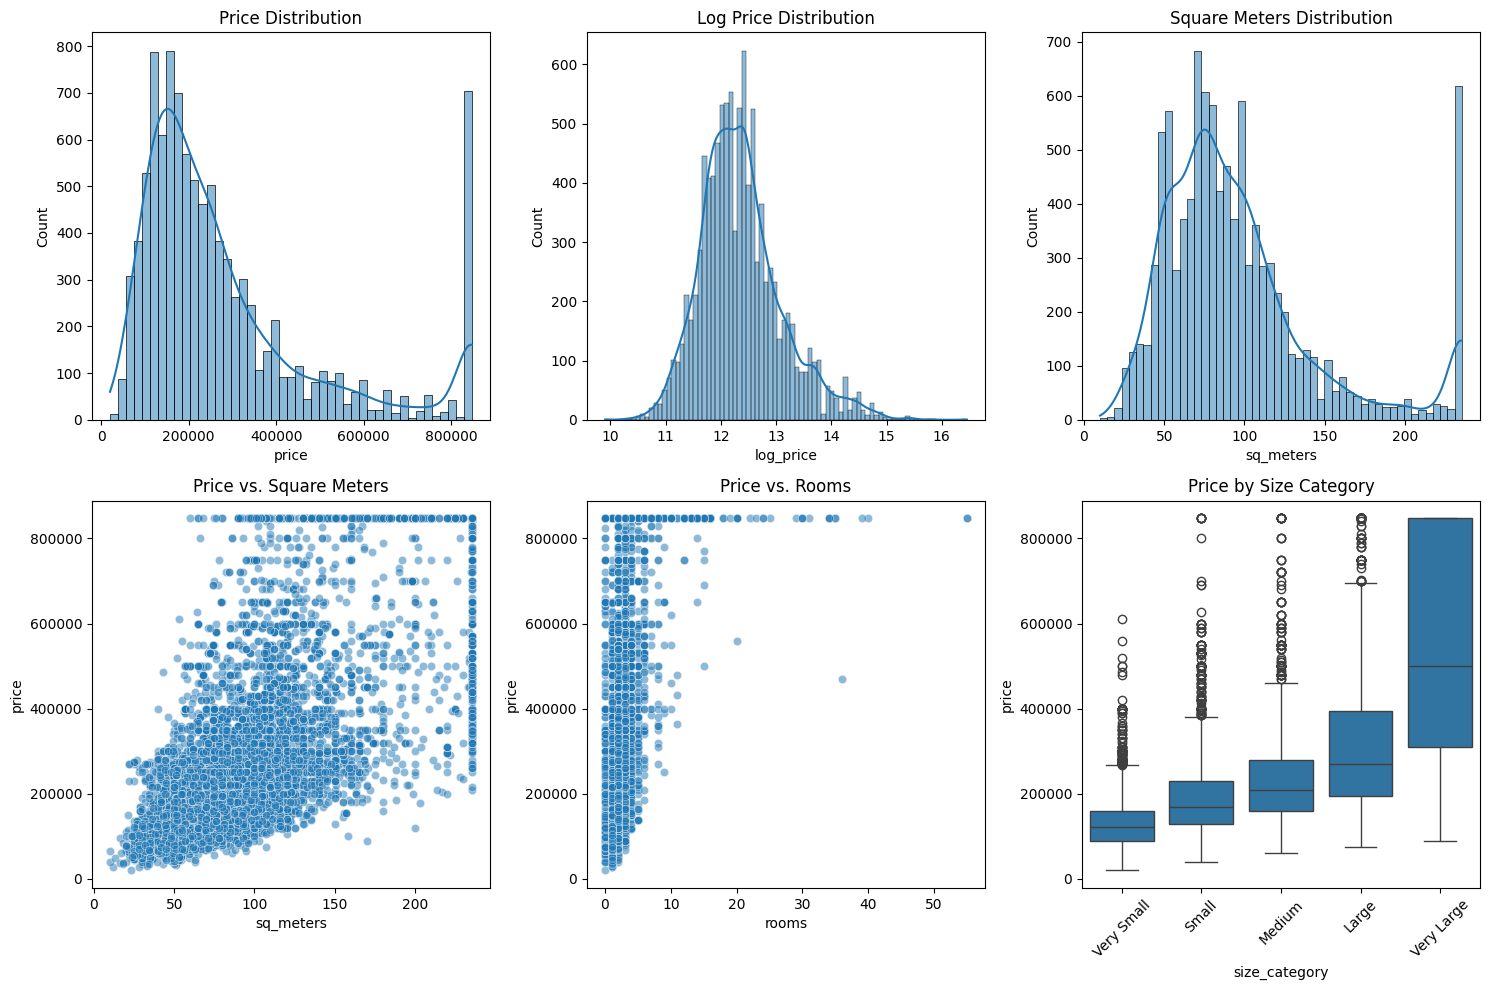

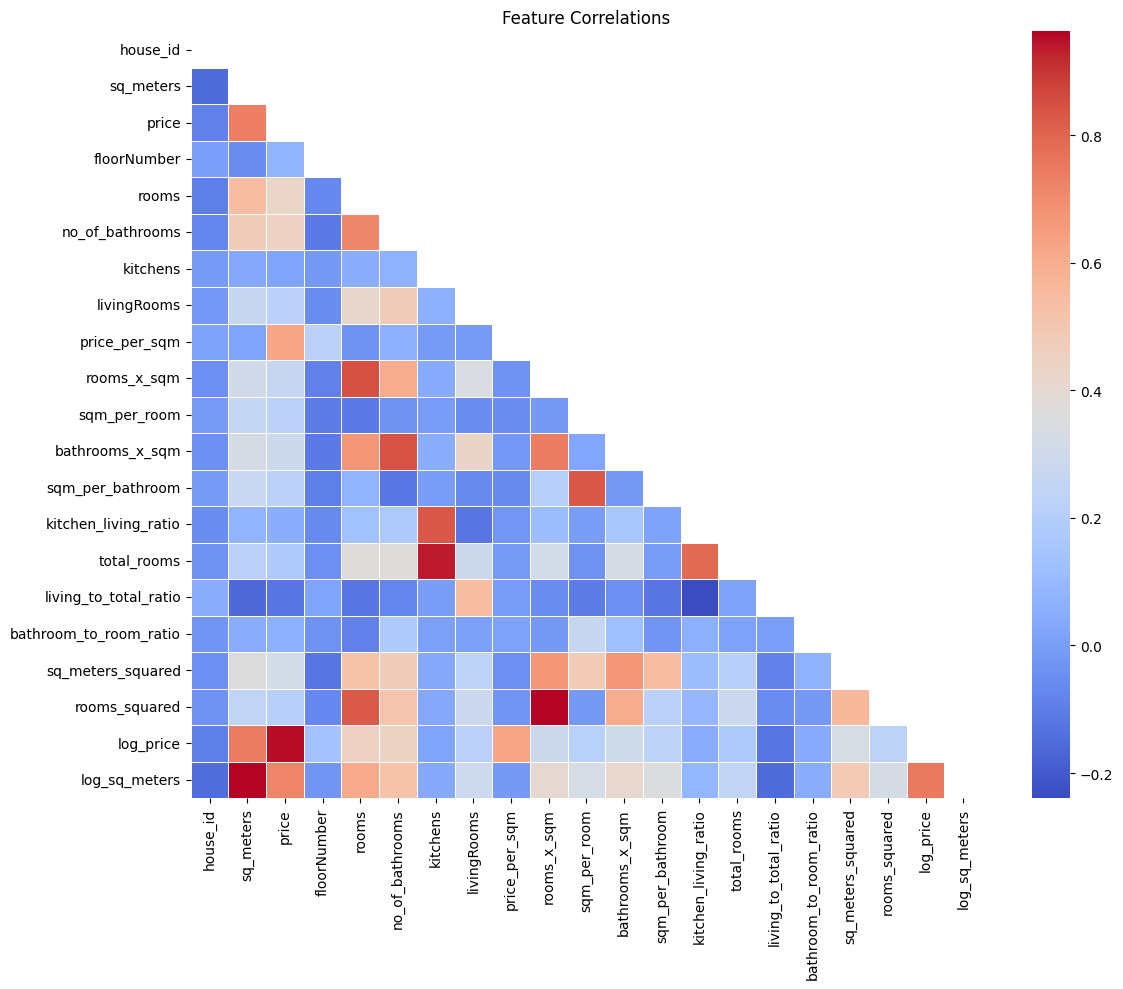

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')

plt.subplot(2, 3, 2)
sns.histplot(df['log_price'], kde=True)
plt.title('Log Price Distribution')

plt.subplot(2, 3, 3)
sns.histplot(df['sq_meters'], kde=True)
plt.title('Square Meters Distribution')

plt.subplot(2, 3, 4)
sns.scatterplot(x='sq_meters', y='price', data=df, alpha=0.5)
plt.title('Price vs. Square Meters')

plt.subplot(2, 3, 5)
sns.scatterplot(x='rooms', y='price', data=df, alpha=0.5)
plt.title('Price vs. Rooms')

plt.subplot(2, 3, 6)
sns.boxplot(x='size_category', y='price', data=df)
plt.title('Price by Size Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

# Craete Train Test split

Select features

In [12]:
df, le = encode_categorical_features(df, method='label')

X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = create_train_test_splits(
    df, target_col='log_price', test_size=0.2
)

In [13]:
for i in le:
    joblib.dump(i[1], f"{i[0]}_encoder.pkl")

In [25]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())  # Corrected the syntax
        ]), numeric_features)  # Ensure numeric_features is defined
    ],
    remainder='passthrough'
)

# Setup training functions for optuna

In [18]:
def train_random_forest(X_train, y_train, params=None):
    """Train RandomForest model with enhanced params"""
    if params is None:
        params = {
            'n_estimators': 200,
            'max_depth': 20,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'bootstrap': True,
            'random_state': 42,
            'n_jobs': -1
        }
    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train, params=None):
    """Train XGBoost model with enhanced params"""
    if params is None:
        params = {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0,
            'reg_alpha': 0,
            'reg_lambda': 1,
            'random_state': 42,
            'n_jobs': -1
        }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model

def train_gradient_boosting(X_train, y_train, params=None):
    """Train Gradient Boosting model"""
    if params is None:
        params = {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'subsample': 0.8,
            'max_features': 'sqrt',
            'random_state': 42
        }
    
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    return model

def train_stacked_model(X_train, y_train, base_models):
    """Train a stacked model with the given base models and improved meta-learner"""
    # Use Ridge as meta-learner for robustness
    meta_model = Ridge(alpha=1.0, random_state=42)
    
    stacked_model = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
    
    stacked_model.fit(X_train, y_train)
    return stacked_model

def train_voting_model(X_train, y_train, estimators):
    """Train a voting regressor ensemble"""
    model = VotingRegressor(estimators=estimators)
    model.fit(X_train, y_train)
    return model

# Evaluate Model


In [24]:
def evaluate_model(model, X_test, y_test, y_orig_test, model_name="Model", plot=True):
    """Evaluate model with comprehensive metrics and diagnostics"""
    
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert log predictions back to original scale
    
    log_rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
    log_mae = mean_absolute_error(y_test, y_pred_log)
    log_r2 = r2_score(y_test, y_pred_log)
    
    rmse = np.sqrt(mean_squared_error(y_orig_test, y_pred))
    mae = mean_absolute_error(y_orig_test, y_pred)
    r2 = r2_score(y_orig_test, y_pred)
    mape = np.mean(np.abs((y_orig_test - y_pred) / y_orig_test)) * 100
    
    print(f"\n{model_name} Evaluation:")
    print(f"Log scale - RMSE: {log_rmse:.4f}, MAE: {log_mae:.4f}, R²: {log_r2:.4f}")
    print(f"Original scale - RMSE: {rmse:.0f}, MAE: {mae:.0f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
    
    if plot:
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 2, 1)
        plt.scatter(y_orig_test, y_pred, alpha=0.5)
        plt.plot([y_orig_test.min(), y_orig_test.max()], [y_orig_test.min(), y_orig_test.max()], 'r--')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.title(f'{model_name}: Actual vs Predicted')
        
        # Plot residuals
        plt.subplot(1, 2, 2)
        residuals = y_orig_test - y_pred
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Price')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        
        plt.tight_layout()
        plt.show()
        
        # Histogram of percent errors
        plt.figure(figsize=(10, 6))
        percent_errors = (y_orig_test - y_pred) / y_orig_test * 100
        plt.hist(percent_errors, bins=50, alpha=0.75)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.xlabel('Percent Error')
        plt.ylabel('Frequency')
        plt.title(f'{model_name}: Distribution of Percent Errors')
        plt.xlim(-100, 100)  # Focus on the main part of the distribution
        plt.tight_layout()
        plt.show()
    
    return {
        'model_name': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'log_rmse': log_rmse,
        'log_r2': log_r2
    }


# Optimize Hyperparameters with optuna

In [25]:
def optimize_random_forest(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    
    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        fold_score = mean_squared_error(y_val_fold, preds)
        scores.append(fold_score)
    
    # Return mean MSE
    return np.mean(scores)

def optimize_xgboost(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }
    
    model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
    
    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        fold_score = mean_squared_error(y_val_fold, preds)
        scores.append(fold_score)
    
    # Return mean MSE
    return np.mean(scores)

def optimize_gradient_boosting(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    
    model = GradientBoostingRegressor(**params, random_state=42)
    
    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        fold_score = mean_squared_error(y_val_fold, preds)
        scores.append(fold_score)
    
    # Return mean MSE
    return np.mean(scores)

# Run and save study

[I 2025-04-02 02:42:52,459] A new study created in memory with name: no-name-00993b07-d816-4a67-b720-75fca0469a32



Optimizing Random Forest parameters...


[I 2025-04-02 02:42:54,849] Trial 0 finished with value: 0.14425810484612295 and parameters: {'n_estimators': 282, 'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.14425810484612295.
[I 2025-04-02 02:42:55,690] Trial 1 finished with value: 0.1762018089938698 and parameters: {'n_estimators': 133, 'max_depth': 35, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.14425810484612295.
[I 2025-04-02 02:42:57,700] Trial 2 finished with value: 0.17182302573976171 and parameters: {'n_estimators': 218, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.14425810484612295.
[I 2025-04-02 02:43:00,187] Trial 3 finished with value: 0.16577096083869555 and parameters: {'n_estimators': 497, 'max_depth': 32, 'min_samples_split': 12, 'min_samples_leaf': 2, '


Best Random Forest parameters:
    n_estimators: 204
    max_depth: 35
    min_samples_split: 5
    min_samples_leaf: 1
    max_features: None
    bootstrap: True


<Figure size 1000x600 with 0 Axes>

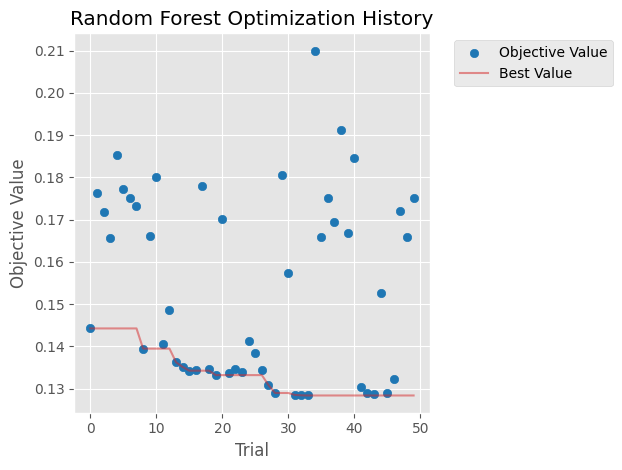

[I 2025-04-02 02:44:36,661] A new study created in memory with name: no-name-abd5502b-0039-439b-875b-91afe111370a



Optimizing XGBoost parameters...


[I 2025-04-02 02:44:39,813] Trial 0 finished with value: 0.15457949783182087 and parameters: {'n_estimators': 429, 'learning_rate': 0.022063363471254756, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7896185498139208, 'colsample_bytree': 0.7582321694332311, 'gamma': 2.81267011513944, 'reg_alpha': 7.930634314428326, 'reg_lambda': 3.9604307717469025}. Best is trial 0 with value: 0.15457949783182087.
[I 2025-04-02 02:44:41,428] Trial 1 finished with value: 0.1578172990589797 and parameters: {'n_estimators': 364, 'learning_rate': 0.09197113632814993, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8128988810224919, 'colsample_bytree': 0.6980387927969935, 'gamma': 3.4598013206920095, 'reg_alpha': 9.930497587258078, 'reg_lambda': 0.7775459241709481}. Best is trial 0 with value: 0.15457949783182087.
[I 2025-04-02 02:44:43,078] Trial 2 finished with value: 0.145305689968719 and parameters: {'n_estimators': 313, 'learning_rate': 0.06047805026706496, 'max_depth': 5, 'min_child_we


Best XGBoost parameters:
    n_estimators: 273
    learning_rate: 0.09349960978892632
    max_depth: 11
    min_child_weight: 4
    subsample: 0.6048624790524025
    colsample_bytree: 0.7032695405444434
    gamma: 0.06074630172323214
    reg_alpha: 1.279347359788806
    reg_lambda: 2.354769298265351


<Figure size 1000x600 with 0 Axes>

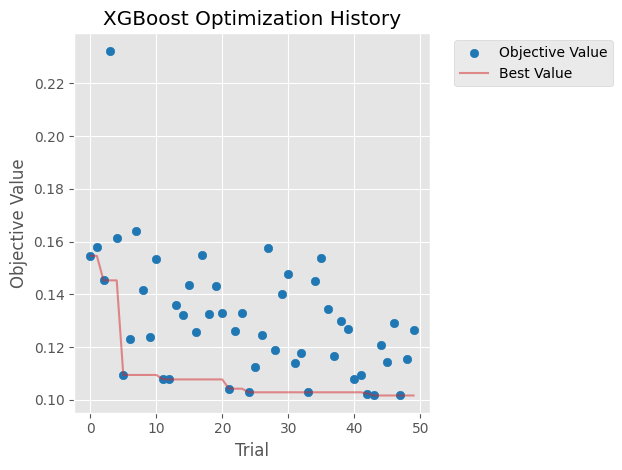

[I 2025-04-02 02:47:15,755] A new study created in memory with name: no-name-149d838d-9406-4b66-895b-79e8102f5632



Optimizing Gradient Boosting parameters...


[I 2025-04-02 02:47:27,691] Trial 0 finished with value: 0.12041729133184001 and parameters: {'n_estimators': 309, 'learning_rate': 0.07369485277825676, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.9005651968261841, 'max_features': 'log2'}. Best is trial 0 with value: 0.12041729133184001.
[I 2025-04-02 02:47:35,070] Trial 1 finished with value: 0.12657629728649383 and parameters: {'n_estimators': 200, 'learning_rate': 0.08158429581221625, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7891970101914978, 'max_features': 'log2'}. Best is trial 0 with value: 0.12041729133184001.
[I 2025-04-02 02:47:54,894] Trial 2 finished with value: 0.11641423122819686 and parameters: {'n_estimators': 154, 'learning_rate': 0.030071483552367162, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 10, 'subsample': 0.8542578505562679, 'max_features': None}. Best is trial 2 with value: 0.11641423122819686.
[I 2025-04-02 02:48:30,188] 


Best Gradient Boosting parameters:
    n_estimators: 323
    learning_rate: 0.08365988187316406
    max_depth: 6
    min_samples_split: 19
    min_samples_leaf: 2
    subsample: 0.7590022875196785
    max_features: None


<Figure size 1000x600 with 0 Axes>

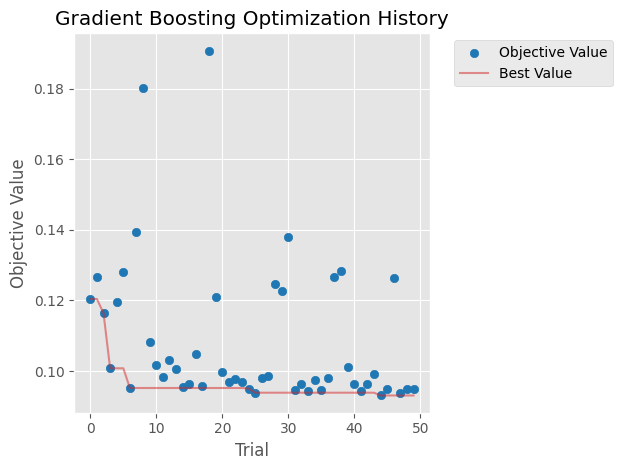


Training models with optimized parameters...


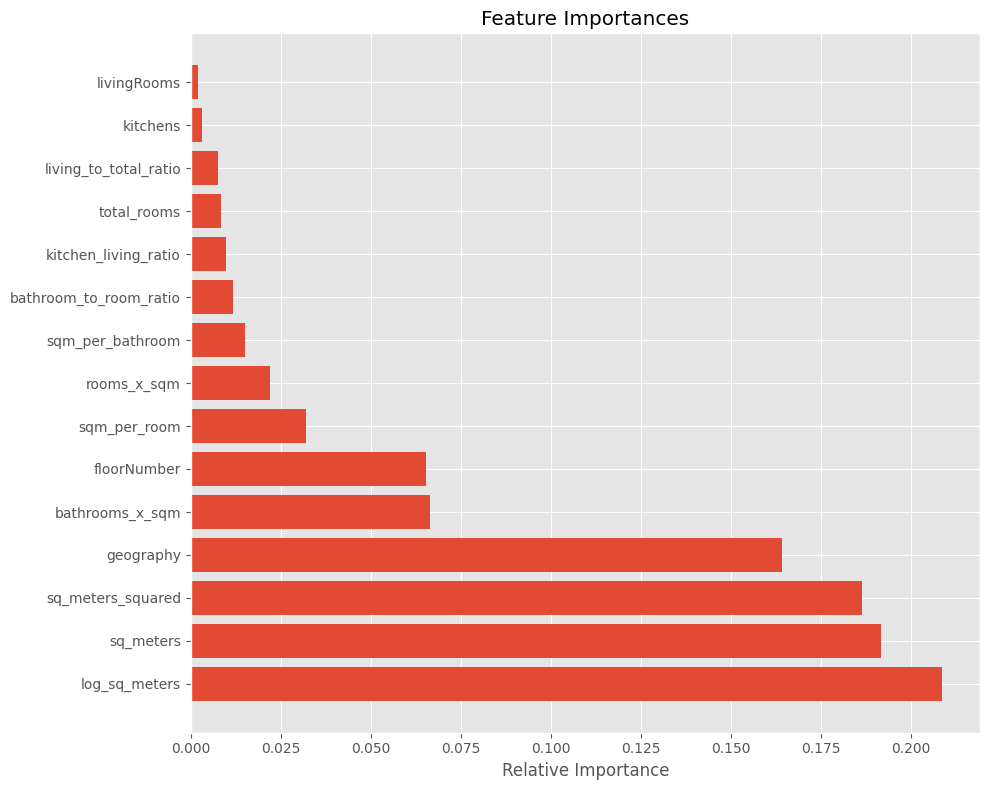

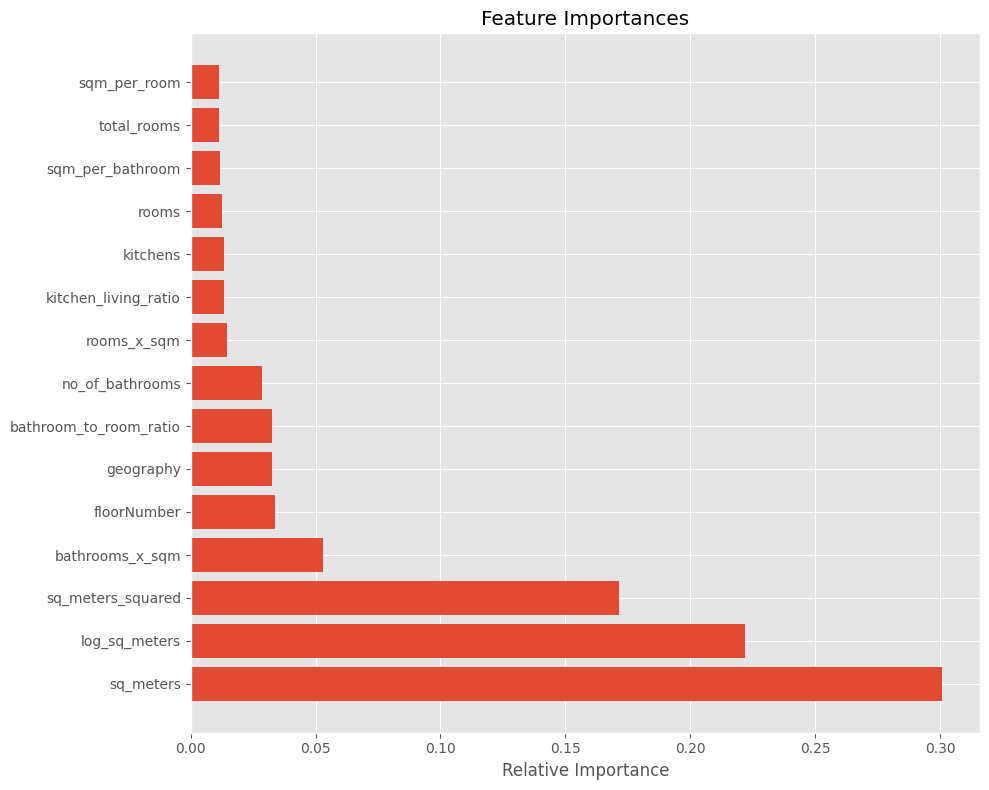


Training Stacked Ensemble model...

Training Voting Ensemble model...

Evaluating Random Forest...

Random Forest Evaluation:
Log scale - RMSE: 0.3464, MAE: 0.2585, R²: 0.7794
Original scale - RMSE: 189651, MAE: 89770, R²: 0.1746, MAPE: 28.44%


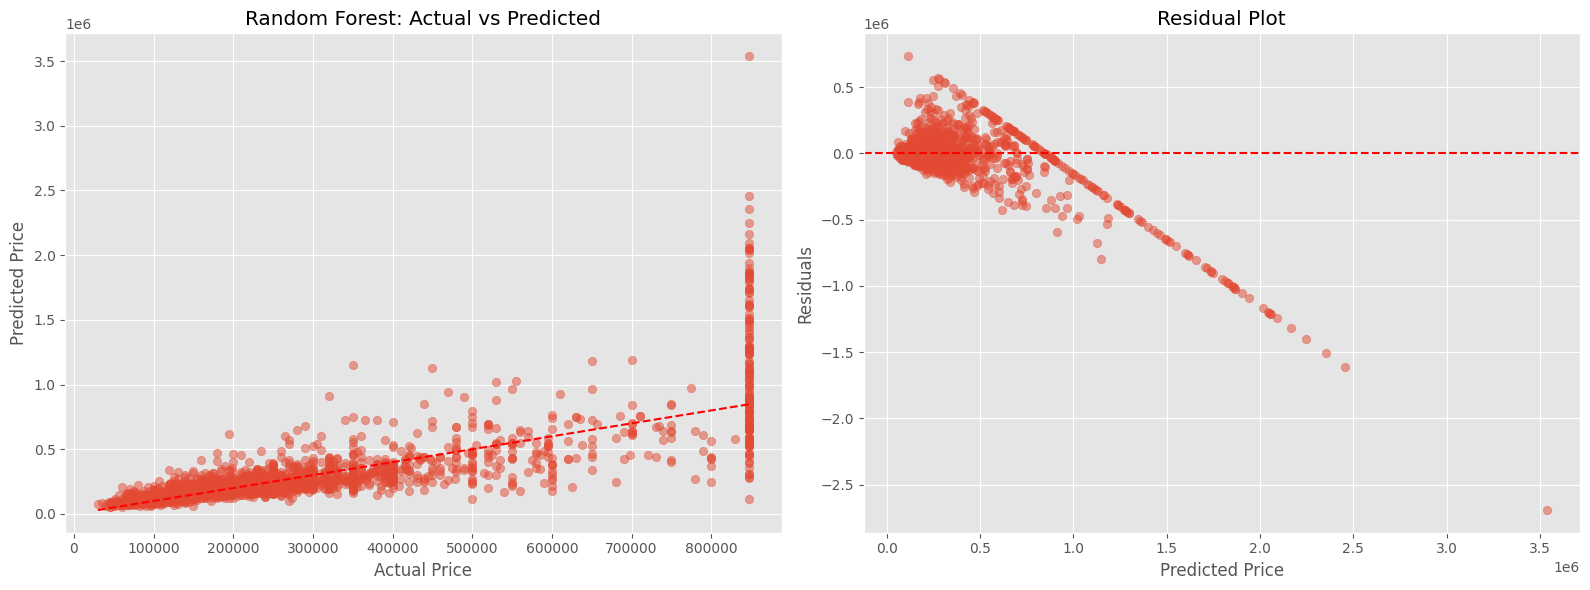

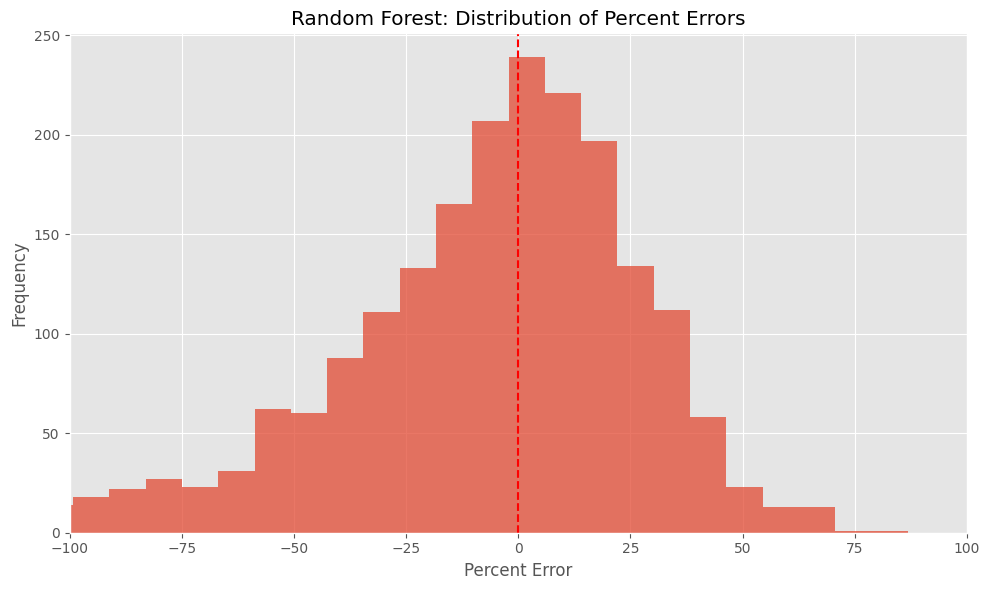


Evaluating XGBoost...

XGBoost Evaluation:
Log scale - RMSE: 0.3114, MAE: 0.2378, R²: 0.8217
Original scale - RMSE: 194689, MAE: 87531, R²: 0.1302, MAPE: 26.34%


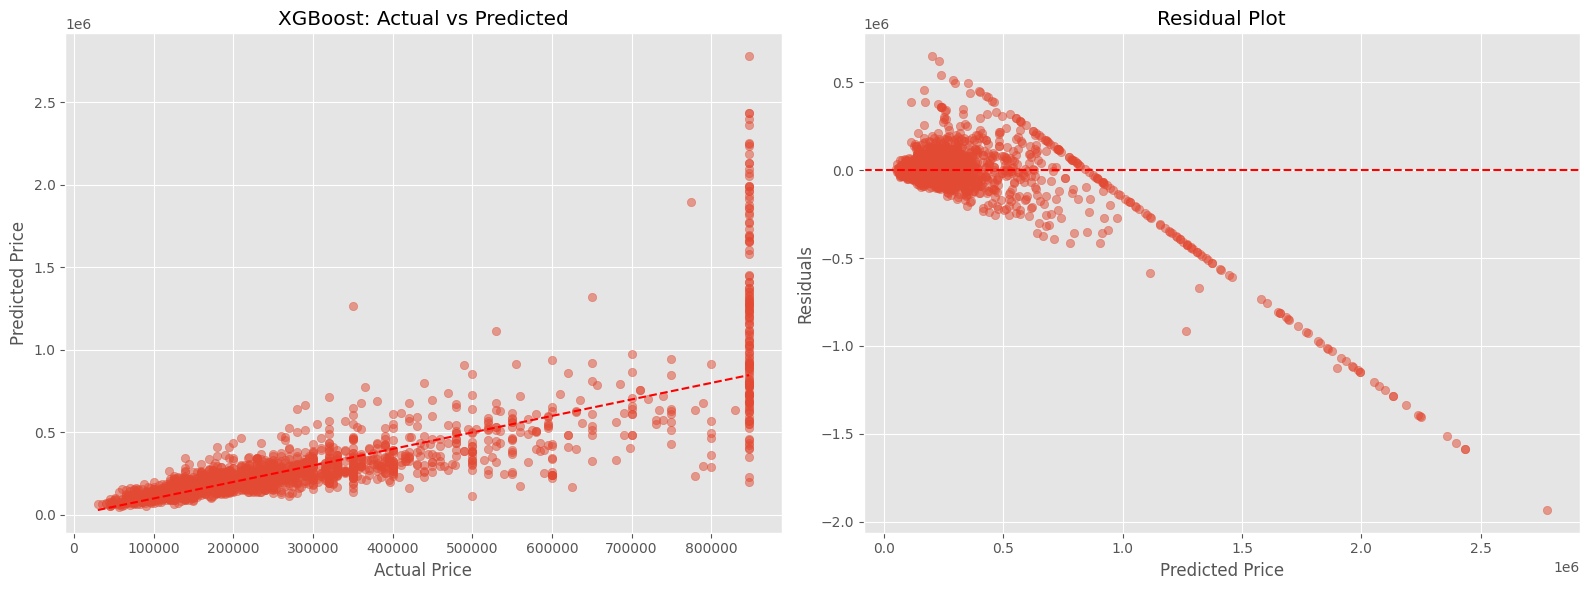

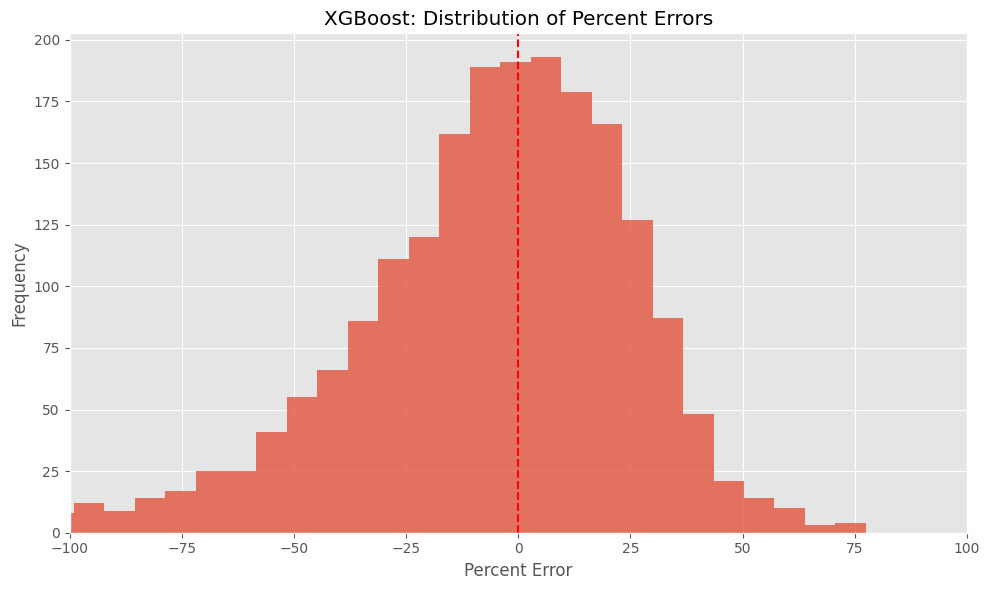


Evaluating Gradient Boosting...

Gradient Boosting Evaluation:
Log scale - RMSE: 0.2990, MAE: 0.2312, R²: 0.8357
Original scale - RMSE: 217082, MAE: 89514, R²: -0.0815, MAPE: 26.12%


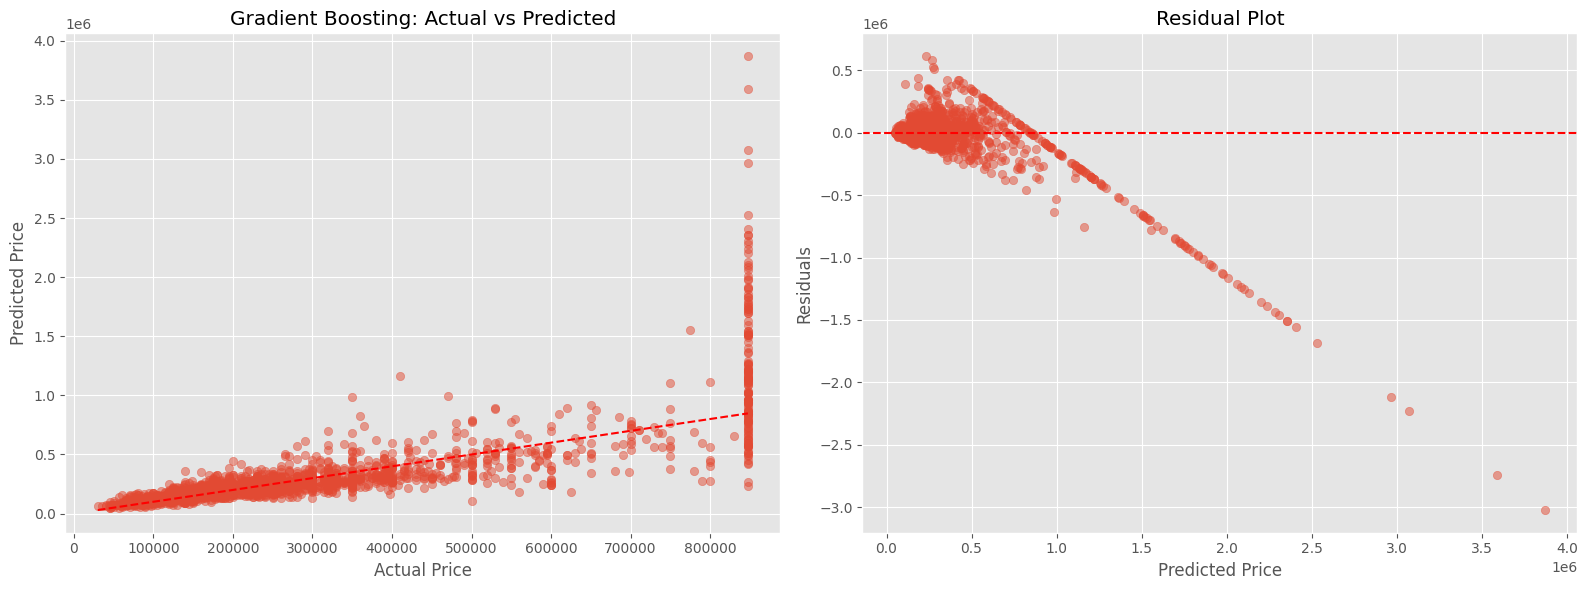

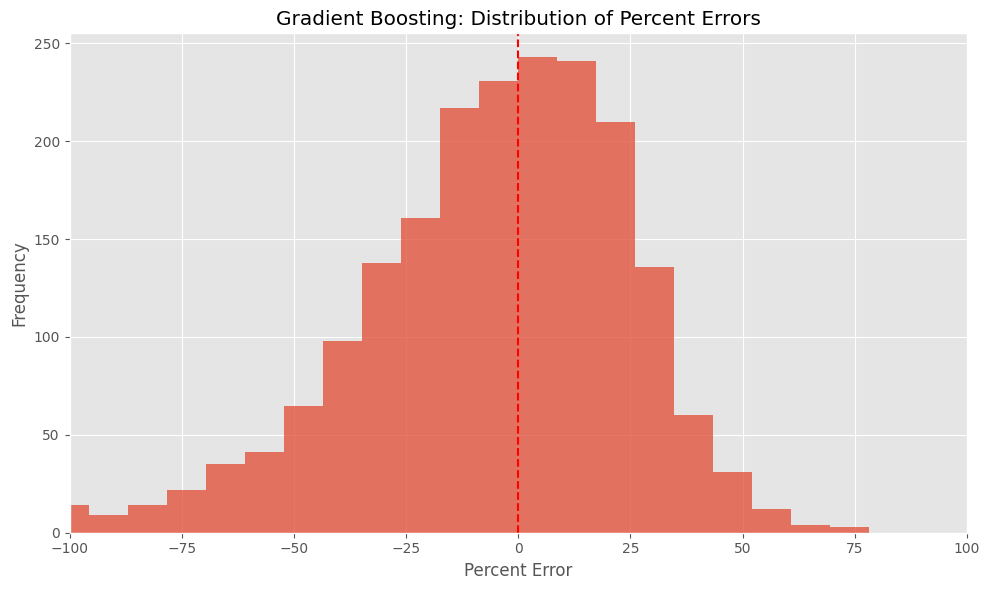


Evaluating Stacked Ensemble...

Stacked Ensemble Evaluation:
Log scale - RMSE: 0.2976, MAE: 0.2301, R²: 0.8372
Original scale - RMSE: 215122, MAE: 89134, R²: -0.0620, MAPE: 25.99%


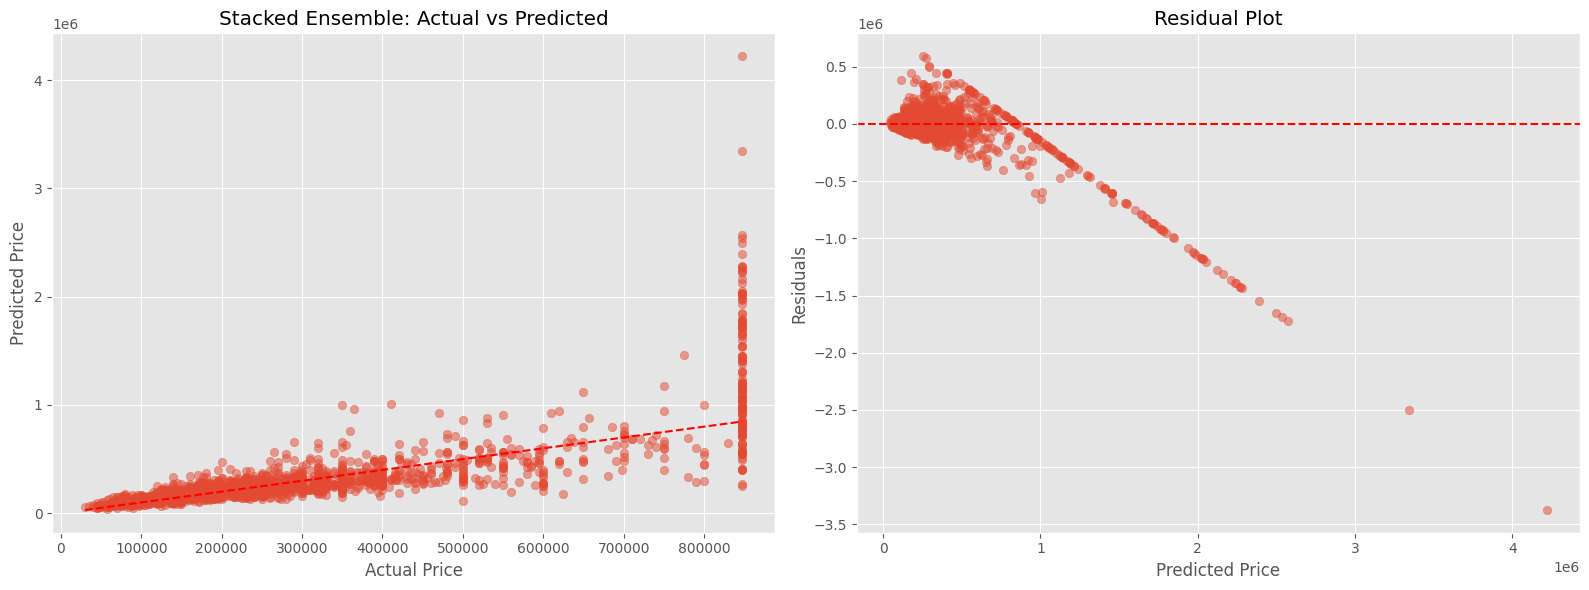

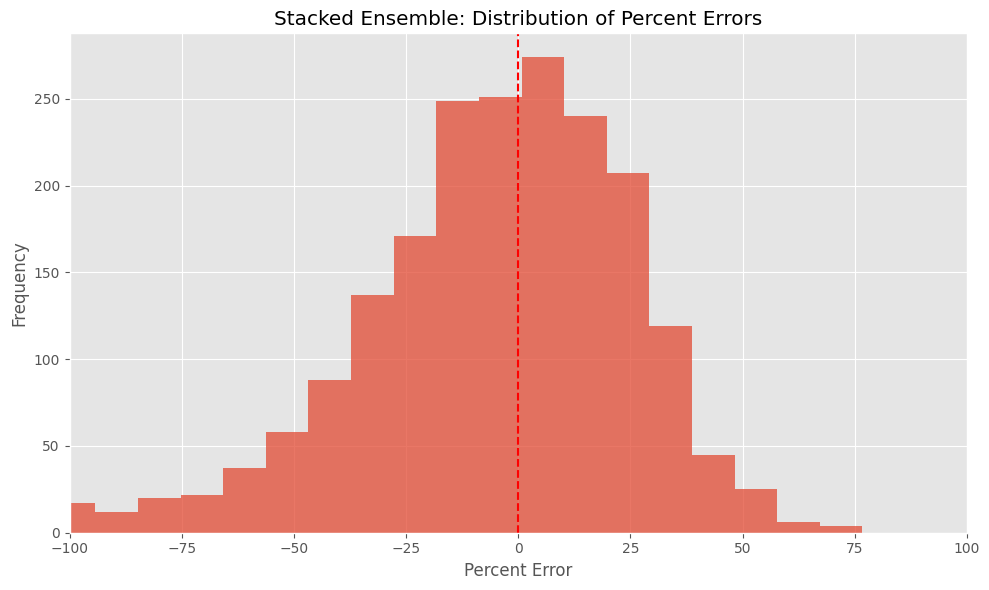


Evaluating Voting Ensemble...

Voting Ensemble Evaluation:
Log scale - RMSE: 0.3089, MAE: 0.2362, R²: 0.8246
Original scale - RMSE: 189973, MAE: 86028, R²: 0.1718, MAPE: 26.11%


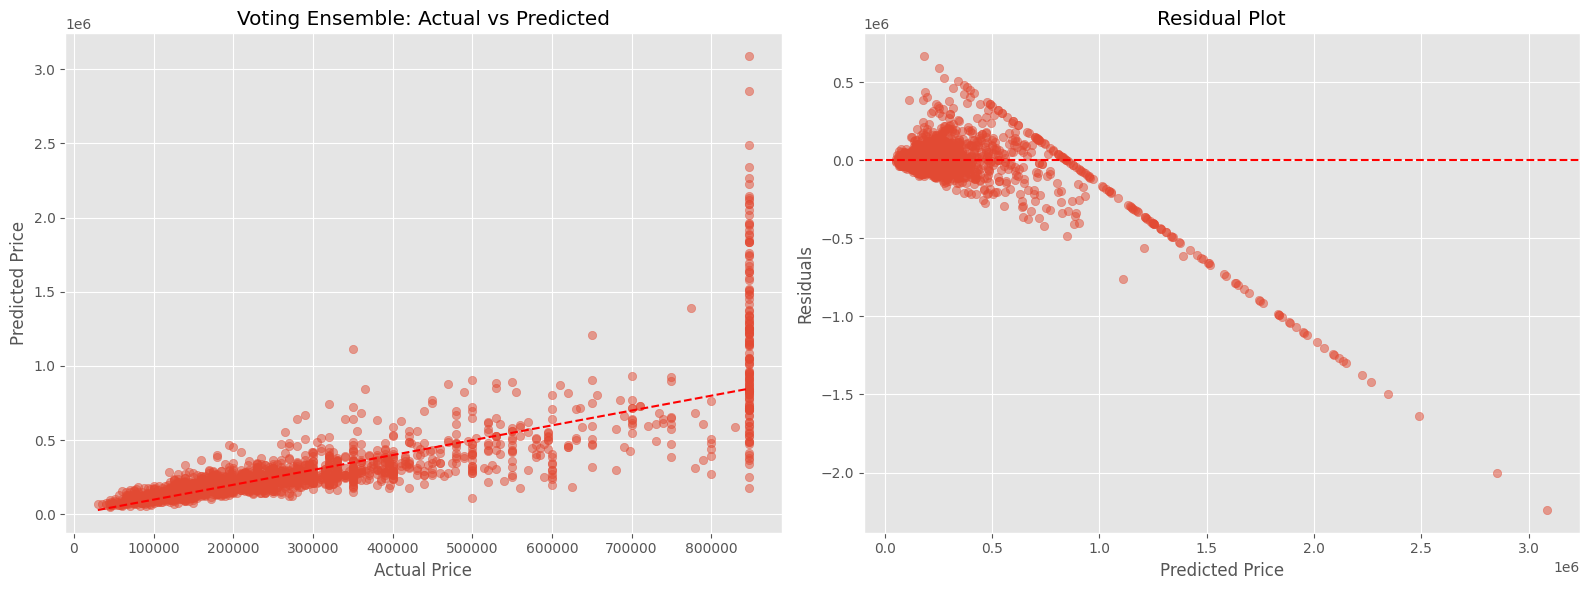

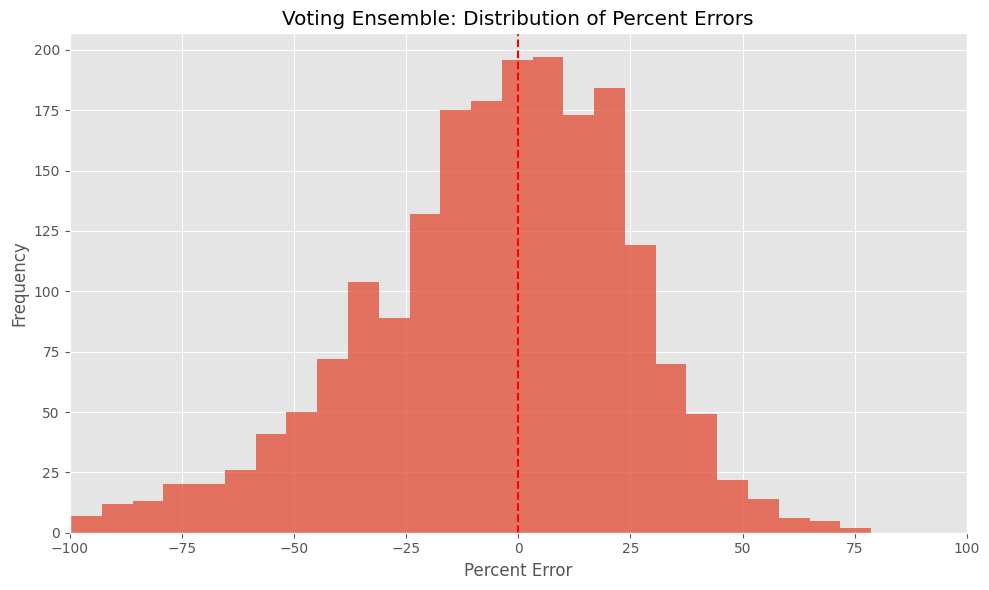


Model Comparison:
                            rmse           mae        r2       mape  log_rmse  \
model_name                                                                      
Random Forest      189650.895052  89770.311290  0.174592  28.437169  0.346415   
Voting Ensemble    189972.784761  86028.208411  0.171787  26.107151  0.308856   
XGBoost            194689.136091  87530.570312  0.130154  26.341785  0.311399   
Stacked Ensemble   215121.725024  89134.052555 -0.062008  25.985817  0.297584   
Gradient Boosting  217082.160852  89514.407216 -0.081452  26.119184  0.298969   

                     log_r2  
model_name                   
Random Forest      0.779401  
Voting Ensemble    0.824644  
XGBoost            0.821744  
Stacked Ensemble   0.837210  
Gradient Boosting  0.835690  


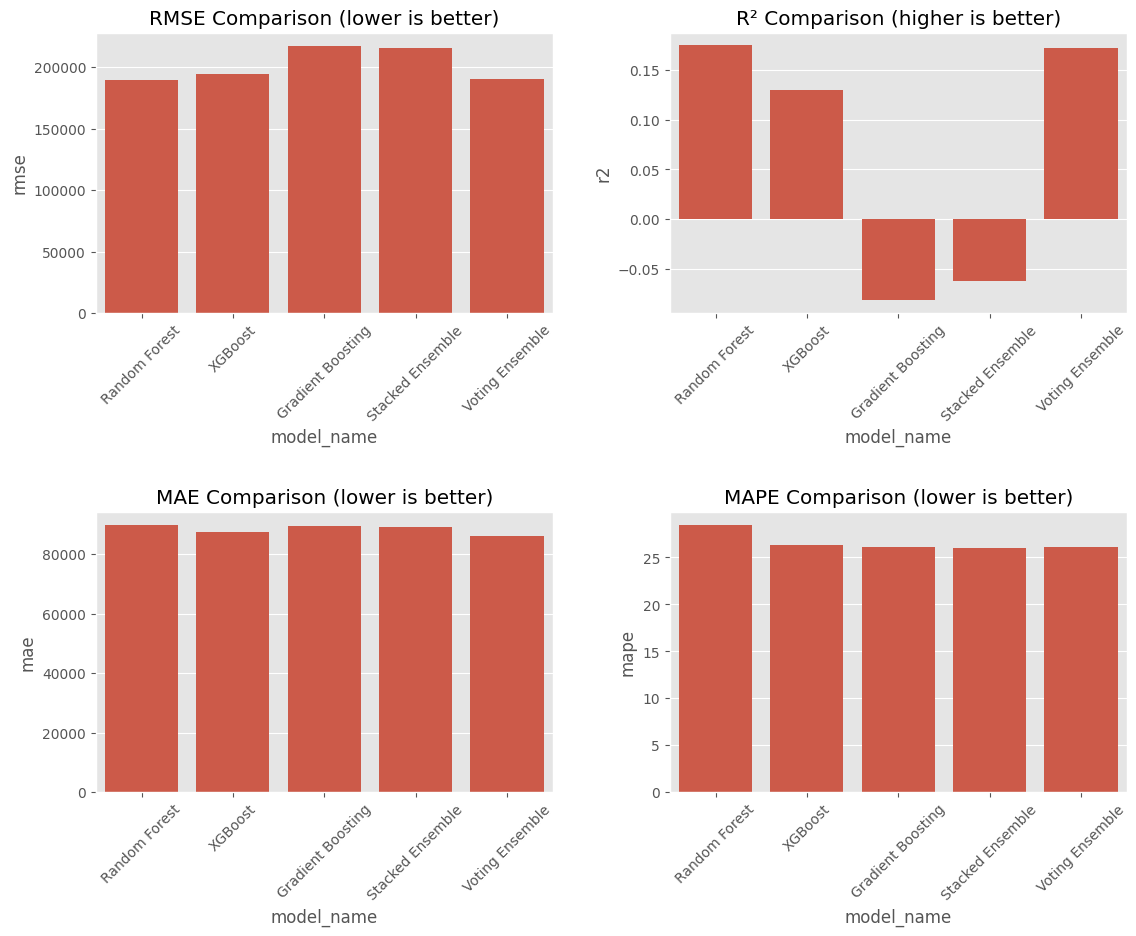


Best model: Random Forest

Worst predictions (highest percent error):
      Actual      Predicted          Error  Percent_Error  sq_meters  rooms  \
5272  847500  111594.910775  735905.089225      86.832459       65.0      1   
3393  500000  114001.950133  385998.049867      77.199610       67.0      2   
7349  600000  178330.703818  421669.296182      70.278216      100.0      7   
5350  800000  247188.146463  552811.853537      69.101482      115.0      2   
1113  560000  173619.090432  386380.909568      68.996591      102.0      2   
3773  540000  169689.471668  370310.528332      68.576024       72.0      2   
7720  847500  276023.198058  571476.801942      67.430891      121.0      2   
1111  847500  282548.138834  564951.861166      66.660987      173.0      4   
1112  625000  209351.976377  415648.023623      66.503684      113.0      2   
37    780000  273498.407490  506501.592510      64.936102      114.0      0   

      no_of_bathrooms  size_category  
5272                

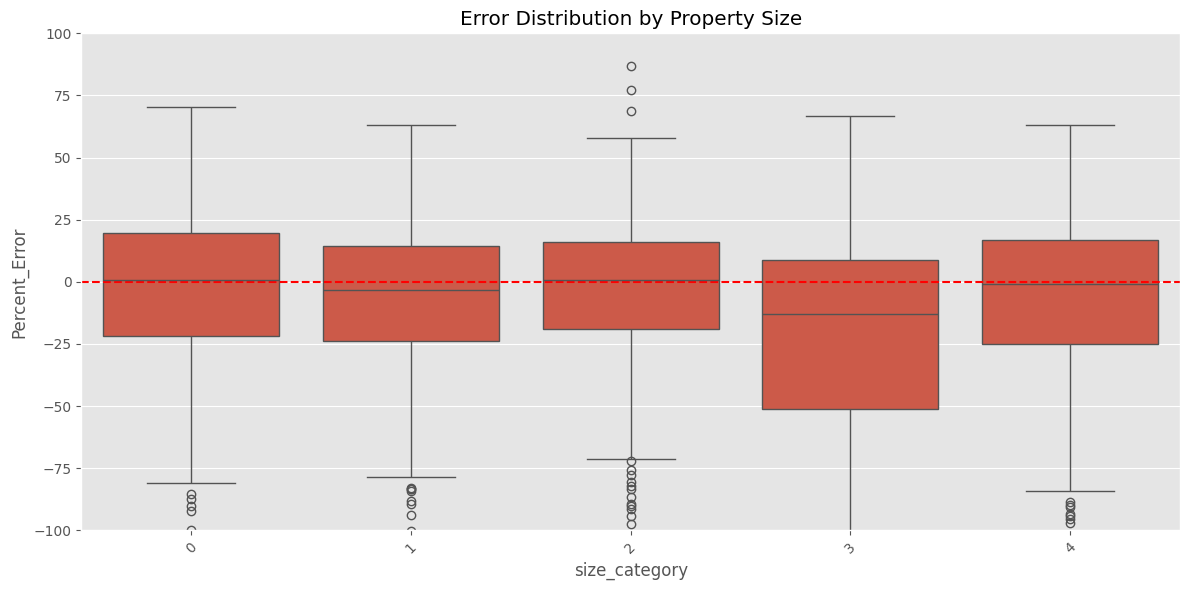

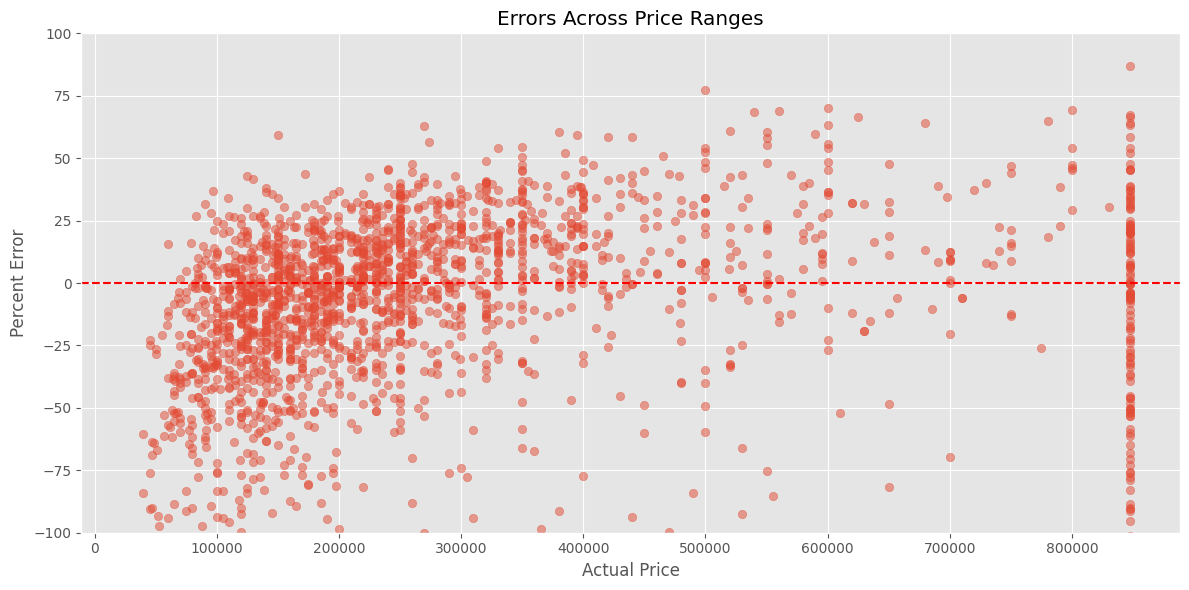

In [26]:
def run_and_save_study(objective, n_trials=100, study_name="study"):
    """Run an Optuna study with improved tracking"""
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=n_trials)
    
    print(f"\nBest {study_name} parameters:")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")
    
    # Plot optimization history
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title(f'{study_name} Optimization History')
    plt.tight_layout()
    plt.show()
    
    return study.best_params

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nOptimizing Random Forest parameters...")
rf_params = run_and_save_study(optimize_random_forest, n_trials=50, study_name="Random Forest")

print("\nOptimizing XGBoost parameters...")
xgb_params = run_and_save_study(optimize_xgboost, n_trials=50, study_name="XGBoost")

print("\nOptimizing Gradient Boosting parameters...")
gb_params = run_and_save_study(optimize_gradient_boosting, n_trials=50, study_name="Gradient Boosting")

print("\nTraining models with optimized parameters...")

rf_model = train_random_forest(X_train, y_train, rf_params)
xgb_model = train_xgboost(X_train, y_train, xgb_params)
gb_model = train_gradient_boosting(X_train, y_train, gb_params)

rf_importance = plot_feature_importance(rf_model, X_train, figsize=(10, 8), top_n=15)
xgb_importance = plot_feature_importance(xgb_model, X_train, figsize=(10, 8), top_n=15)

base_models = [
    ('rf', RandomForestRegressor(**rf_params, random_state=42, n_jobs=-1)),
    ('xgb', xgb.XGBRegressor(**xgb_params, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(**gb_params, random_state=42))
]

print("\nTraining Stacked Ensemble model...")
stacked_model = train_stacked_model(X_train, y_train, base_models)

print("\nTraining Voting Ensemble model...")
voting_model = train_voting_model(X_train, y_train, base_models)

models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Gradient Boosting': gb_model,
    'Stacked Ensemble': stacked_model,
    'Voting Ensemble': voting_model
}

eval_results = []

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    result = evaluate_model(model, X_test, y_test, y_orig_test, model_name=name)
    eval_results.append(result)

# Create comparisontable
results_df = pd.DataFrame(eval_results)
results_df = results_df.set_index('model_name')
print("\nModel Comparison:")
print(results_df.sort_values('rmse'))

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.barplot(x=results_df.index, y='rmse', data=results_df)
plt.title('RMSE Comparison (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(2, 2, 2)
sns.barplot(x=results_df.index, y='r2', data=results_df)
plt.title('R² Comparison (higher is better)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(2, 2, 3)
sns.barplot(x=results_df.index, y='mae', data=results_df)
plt.title('MAE Comparison (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(2, 2, 4)
sns.barplot(x=results_df.index, y='mape', data=results_df)
plt.title('MAPE Comparison (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.tight_layout(pad=3.0)
plt.show()

best_model_name = results_df['rmse'].idxmin()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
errors = y_orig_test - y_pred
percent_errors = (errors / y_orig_test) * 100

error_df = pd.DataFrame({
    'Actual': y_orig_test,
    'Predicted': y_pred,
    'Error': errors,
    'Percent_Error': percent_errors
})

# Add relevant features from test set for error analysis
for col in ['sq_meters', 'rooms', 'no_of_bathrooms', 'size_category']:
    if col in X_test.columns:
        error_df[col] = X_test[col].values
    elif col == 'size_category' and 'size_category' in df.columns:
        # Retrieve from original dataframe using index
        error_df[col] = df.loc[X_test.index, 'size_category'].values

# Analyze where the model performs poorly
print("\nWorst predictions (highest percent error):")
print(error_df.sort_values('Percent_Error', ascending=False).head(10))

print("\nBest predictions (lowest percent error):")
print(error_df.sort_values('Percent_Error', ascending=True).head(10))

# Analyze errors by property size
if 'size_category' in error_df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='size_category', y='Percent_Error', data=error_df)
    plt.title('Error Distribution by Property Size')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylim(-100, 100)  # Focus on main part of distribution
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
# Analyze errors across price ranges
plt.figure(figsize=(12, 6))
plt.scatter(error_df['Actual'], error_df['Percent_Error'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Percent Error')
plt.title('Errors Across Price Ranges')
plt.ylim(-100, 100)  # Focus on main part of distribution
plt.tight_layout()
plt.show()

# Save the best model

In [28]:
joblib.dump(best_model, f'best_house_price_model_{best_model_name}.pkl')
joblib.dump(preprocessor, 'house_price_preprocessor.pkl')

['house_price_preprocessor.pkl']

# Predict house data functions

# TODO 
- fix so that everything goes in a pre-processing script( user has to input only a handful of values)
- add sizse of room, maybe ditch encoder

In [1]:
import joblib
import pandas as pd
import numpy as np

In [2]:
best_model = joblib.load("best_house_price_model_Random Forest.pkl")
preprocessor = joblib.load("house_price_preprocessor.pkl")
geography_encoder = joblib.load("geography_encoder.pkl")
size_category_encoder = joblib.load("size_category_encoder.pkl")

In [59]:
new_data = pd.DataFrame({
    'sq_meters': [102],
    'geography': ['Agios Ioannis (Athens - Center)'],
    'floorNumber': [10],
    'rooms': [2],
    'no_of_bathrooms': [2],
    'kitchens': [1],
    'livingRooms': [1]
})


In [17]:
def engineer_features(df):
    """Create new features with sophisticated domain-specific logic"""
    df_new = df.copy()
    
    # Basic features (from original code)
    if 'price' in df.columns and 'sq_meters' in df.columns:
        df_new['price_per_sqm'] = df['price'] / df['sq_meters']
    
    if 'rooms' in df.columns and 'sq_meters' in df.columns:
        df_new['rooms_x_sqm'] = df['rooms'] * df['sq_meters']
        df_new['sqm_per_room'] = df['sq_meters'] / (df['rooms'] + 0.1)  # Avoid division by zero
    
    if 'no_of_bathrooms' in df.columns and 'sq_meters' in df.columns:
        df_new['bathrooms_x_sqm'] = df['no_of_bathrooms'] * df['sq_meters']
        df_new['sqm_per_bathroom'] = df['sq_meters'] / (df['no_of_bathrooms'] + 0.1)
    
    if 'kitchens' in df.columns and 'livingRooms' in df.columns:
        df_new['kitchen_living_ratio'] = df['kitchens'] / (df['livingRooms'] + 0.1)
    
    # Advanced features
    if all(col in df.columns for col in ['rooms', 'no_of_bathrooms', 'kitchens', 'livingRooms']):
        df_new['total_rooms'] = df['rooms'] + df['no_of_bathrooms'] + df['kitchens'] + df['livingRooms']
        df_new['living_to_total_ratio'] = df['livingRooms'] / (df_new['total_rooms'] + 0.1)
        df_new['bathroom_to_room_ratio'] = df['no_of_bathrooms'] / (df['rooms'] + 0.1)
    
    # Polynomial features for key metrics
    if 'sq_meters' in df.columns:
        df_new['sq_meters_squared'] = df['sq_meters'] ** 2
    
    if 'rooms' in df.columns:
        df_new['rooms_squared'] = df['rooms'] ** 2
    
    # Log transform for target and skewed features
    if 'price' in df.columns:
        df_new['log_price'] = np.log1p(df['price'])
    
    if 'sq_meters' in df.columns:
        df_new['log_sq_meters'] = np.log1p(df['sq_meters'])
    
    def categorize_size(sq_meters):
        if sq_meters < 50:
            return 'Very Small'
        elif sq_meters < 80:
            return 'Small'
        elif sq_meters < 120:
            return 'Medium'
        elif sq_meters < 180:
            return 'Large'
        else:
            return 'Very Large'
    
    # Apply the function to create the size_category feature
    if 'sq_meters' in df.columns:
        df_new['size_category'] = df['sq_meters'].apply(categorize_size)
    return df_new

In [92]:
new_data_dict = {
    'sq_meters': 168,
    'geography': 'Agios Thomas (Athens - Center)',
    'floorNumber': 9,
    'rooms': 2,
    'no_of_bathrooms': 1,
    'kitchens': 1,
    'livingRooms': 2
}

In [57]:
def pre_process(df):
    new_data = df.copy()
    new_data = engineer_features(new_data)
    new_data["geography"] = geography_encoder.transform(new_data["geography"])
    new_data["size_category"] = size_category_encoder.transform(new_data["size_category"])
    new_data = preprocessor.transform(new_data)
    return new_data
    

In [96]:
def predict_single_house(**kwargs):
    
    df_single = pd.DataFrame([kwargs])
    predicted_price = make_prediction(df_single)[0]
    
    return predicted_price

In [84]:
def make_prediction(df):
    df = pre_process(df)
    result = best_model.predict(df)
    return np.expm1(result)


In [97]:
predict_single_house(**new_data_dict)

/home/smitsis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


71228.95828102336

In [3]:
geography_encoder.classes_

array(['A Nekrotafeio (Athens - Center)',
       'Ag. Meletiou - Viktorias Sq. - Marni (Athens - Center)',
       'Agios Artemios (Athens - Center)',
       'Agios Eleftherios (Athens - Center)',
       'Agios Eleftherios - Probona - Rizoupoli (Athens - Center)',
       'Agios Ioannis (Athens - Center)',
       'Agios Nikolaos (Athens - Center)',
       'Agios Panteleimonas (Athens - Center)',
       'Agios Sostis (Athens - Center)', 'Agios Thomas (Athens - Center)',
       'Akadimia (Athens - Center)', 'Akropoli (Athens - Center)',
       'Alsos (Athens - Center)', 'Alsos Pagkratiou (Athens - Center)',
       'Ampelokipoi (Athens - Center)',
       'Ampelokipoi - Pentagon (Athens - Center)',
       'Ano Kipseli - Evelpidon (Athens - Center)',
       'Ano Patisia (Athens - Center)', 'Ano Petralona (Athens - Center)',
       'Athens Medical School (Athens - Center)',
       'Attiki (Athens - Center)', 'Attiko Alsos (Athens - Center)',
       'Center (Athens - Center)', 'Elinoroson (Athe